# SNAP

SNAP serves as a proxy application to model the performance of a modern discrete ordinates neutral particle transport application. SNAP may be considered an update to Sweep3D, intended for hybri
d computing architectures. It is modeled off the Los Alamos National Laboratory code PARTISN. PARTISN solves the linear Boltzmann transport equation (TE), a governing equation for determining the number of n
eutral particles (e.g., neutrons and gamma rays) in a multi-dimensional phase space. SNAP itself is not a particle transport application; SNAP incorporates no actual physics in its available data, nor does i
t use numerical operators specifically designed for particle transport. Rather, SNAP mimics the computational workload, memory requirements, and communication patterns of PARTISN. The equation it solves has 
been composed to use the same number of operations, use the same data layout, and load elements of the arrays in approximately the same order. Although the equation SNAP solves looks similar to the TE, it ha
s no real world relevance.

---
## Parameters - inputFile with only # threads changed

```
! Input from namelist
&invar
  nthreads=72
  nnested=1
  npey=1
  npez=1
  ndimen=3
  nx=20
  lx=0.02
  ny=20
  ly=0.02
  nz=12
  lz=0.012
  ichunk=10
  nmom=4
  nang=80
  ng=72
  mat_opt=1
  src_opt=1
  timedep=1
  it_det=0
  tf=0.01
  nsteps=10
  iitm=5
  oitm=100
  epsi=1.E-4
  fluxp=0
  scatp=0
  fixup=0
  soloutp=1
  angcpy=2
/
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

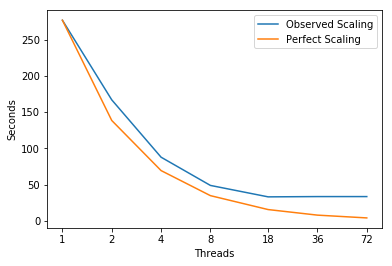

In [3]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[277.0, 167.0, 87.75, 48.75, 32.94444444444444, 33.33333333333333, 33.33333333333333],
        label='Observed Scaling')
ax.plot(Threads, [277.0, 138.5, 69.25, 34.625, 15.38888888888889, 7.694444444444445, 3.8472222222222223],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Intel Software Development Emulator 
| SDE Metrics | SNAP |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.11 |
| **Bytes per Load Inst** | 25.57 |
| **Bytes per Store Inst** | 24.39 |

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz
### 72 Threads - 36 - Cores 2300.0 Mhz
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**  | 143.1 |  44.87 | 33.12 |   16.04  |
|**36 Threads**  | 2509.07 |  807.72 | 558.03 |   58.38  |
|**72 Threads**  | 2391.14 |  792.13 | 581.89 |   42.97  |

---
## Experiment Aggregate Metrics
 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (100.0%)|1.98|0.85|1.03|4.03%|22.66%|36.49%|18.24%|13.75%|1.39%|
|36 (100.0%)|0.79|0.33|0.39|3.19%|20.79%|32.82%|10.54%|8.49%|4.92%|
|72 (100.0%)|0.96|0.17|0.20|8.31%|16.93%|21.85%|14.55%|7.57%|1.03%|

---
## SUBROUTINE dim3_sweep
### Data for entire subroutine (only data members and outer loop structure show)

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (80.9%)|1.82|0.90|1.06|4.37%|21.55%|35.76%|20.79%|14.33%|1.38%|
|36 (65.9%)|0.56|0.29|0.33|4.88%|19.91%|37.08%|14.40%|10.70%|7.13%|
|72 (66.0%)|0.57|0.13|0.14|14.73%|16.13%|24.45%|20.08%|9.58%|1.53%|

```fortran
33   SUBROUTINE dim3_sweep ( ich, id, d1, d2, d3, d4, jd, kd, oct, g, t,  &
 34     iop, reqs, szreq, psii, psij, psik, qtot, ec, vdelt, ptr_in,       &
 35     ptr_out, dinv, flux0, fluxm, jb_in, jb_out, kb_in, kb_out, wmu,    &
 36     weta, wxi, flkx, flky, flkz, t_xs, fmin, fmax )
 37 
 38 !-----------------------------------------------------------------------
 39 !
 40 ! 3-D slab mesh sweeper.
 41 !
 42 !-----------------------------------------------------------------------
 43 
 44     INTEGER(i_knd), INTENT(IN) :: ich, id, d1, d2, d3, d4, jd, kd, oct,&
 45       g, t, iop, szreq
 46 
 47     INTEGER(i_knd), DIMENSION(szreq), INTENT(INOUT) :: reqs
 48 
 49     REAL(r_knd), INTENT(IN) :: vdelt
 50 
 51     REAL(r_knd), INTENT(INOUT) :: fmin, fmax
 52 
 53     REAL(r_knd), DIMENSION(nang), INTENT(IN) :: wmu, weta, wxi
 54 
 55     REAL(r_knd), DIMENSION(nang,cmom), INTENT(IN) :: ec
 56 
 57     REAL(r_knd), DIMENSION(nang,ny,nz), INTENT(INOUT) :: psii
 58 
 59     REAL(r_knd), DIMENSION(nang,ichunk,nz), INTENT(INOUT) :: psij,     &
 60       jb_in, jb_out
 61 
 62     REAL(r_knd), DIMENSION(nang,ichunk,ny), INTENT(INOUT) :: psik,     &
 63       kb_in, kb_out
 64 
 65     REAL(r_knd), DIMENSION(nx,ny,nz), INTENT(IN) :: t_xs
 66 
 67     REAL(r_knd), DIMENSION(nx,ny,nz), INTENT(INOUT) :: flux0
 68 
 69     REAL(r_knd), DIMENSION(nx+1,ny,nz), INTENT(INOUT) :: flkx
 70 
 71     REAL(r_knd), DIMENSION(nx,ny+1,nz), INTENT(INOUT) :: flky
 72 
 73     REAL(r_knd), DIMENSION(nx,ny,nz+1), INTENT(INOUT) :: flkz
 74 
 75     REAL(r_knd), DIMENSION(nang,ichunk,ny,nz), INTENT(IN) :: dinv
 76 
 77     REAL(r_knd), DIMENSION(cmom-1,nx,ny,nz), INTENT(INOUT) :: fluxm
 78 
 79     REAL(r_knd), DIMENSION(cmom,ichunk,ny,nz), INTENT(IN) :: qtot
 80 
 81     REAL(r_knd), DIMENSION(d1,d2,d3,d4), INTENT(IN) :: ptr_in
 82 
 83     REAL(r_knd), DIMENSION(d1,d2,d3,d4), INTENT(OUT) :: ptr_out
 84 !_______________________________________________________________________
 85 !
 86 !   Local variables
 87 !_______________________________________________________________________
 88 
 89     INTEGER(i_knd) :: ist, iclo, ichi, jst, jlo, jhi, kst, klo, khi, k,&
 90       j, ic, i, l, ibl, ibr, ibb, ibt, ibf, ibk
 91 
 92     LOGICAL(l_knd) :: receive
 93 
 94     REAL(r_knd) :: sum_hv
 95 
 96     REAL(r_knd), DIMENSION(nang) :: psi, pc, den
 97 
 98     REAL(r_knd), DIMENSION(nang,4) :: hv, fxhv
        {...}
135 !_______________________________________________________________________
136 !
137 !   Loop over the cells using bounds/stride above
138 !_______________________________________________________________________
139 
140     k_loop:  DO k = klo, khi, kst
141     j_loop:  DO j = jlo, jhi, jst
142     ic_loop: DO ic = iclo, ichi, ist
```
### 3 Most costly loops shown below are within these loops

---
## loop at dim3_sweep.f90: 168

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (15.5%)|2.41|1.28|1.71|0.36%|15.81%|14.23%|2.94%|2.92%|0.03%|
|36 (4.9%)|1.81|0.97|1.30|0.62%|15.53%|37.66%|6.78%|6.40%|1.28%|
|72 (4.6%)|1.22|0.48|0.61|3.37%|15.00%|26.87%|17.50%|7.68%|0.37%|

```fortran
168       DO l = 2, cmom
169         psi = psi + ec(:,l)*qtot(l,ic,j,k)
170       END DO
```

---
## loop at dim3_sweep.f90: 257

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (16.9%)|0.79|0.49|0.46|19.93%|23.50%|38.56%|50.75%|30.93%|5.56%|
|36 (30.7%)|0.12|0.07|0.07|21.27%|20.34%|36.12%|15.60%|11.76%|11.38%|
|72 (30.2%)|0.35|0.03|0.02|57.21%|16.96%|21.73%|18.89%|10.38%|2.25%|

```fortran
251 !_______________________________________________________________________
252 !
253 !     Compute initial solution
254 !_______________________________________________________________________
255 
256       IF ( vdelt /= zero ) THEN
257         pc = ( psi + psii(:,j,k)*mu*hi + psij(:,ic,k)*eta*hj +         &
258           psik(:,ic,j)*xi*hk + ptr_in(:,i,j,k)*vdelt ) * dinv(:,ic,j,k)
259       ELSE
260         pc = ( psi + psii(:,j,k)*mu*hi + psij(:,ic,k)*eta*hj +         &
261           psik(:,ic,j)*xi*hk ) * dinv(:,ic,j,k)
262       END IF
```

--- 
## loop at dim3_sweep.f90: 397

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (19.9%)|1.87|0.94|0.94|3.36%|11.88%|36.01%|12.28%|7.70%|0.40%|
|36 (10.4%)|0.86|0.45|0.45|3.74%|13.00%|58.47%|13.52%|7.07%|4.46%|
|72 (7.8%)|0.90|0.27|0.25|12.64%|11.57%|47.94%|28.93%|7.82%|1.59%|

```fortran
397         DO l = 1, cmom-1
398           fluxm(l,i,j,k) = fluxm(l,i,j,k) + SUM( ec(:,l+1)*psi )
399         END DO
```


---
```fortran
411 !_______________________________________________________________________
412 !
413 !   Finish the loops
414 !_______________________________________________________________________
415 
416     END DO ic_loop
417     END DO j_loop
418     END DO k_loop
419 !__________________________
```

## Discussion
When scaled up across threads around 27% of the time is spent in `kmp_wait_release.h`. However the if statement at line 257 takes an increasing chunck of the time.  The `IF` path accounts for almost all the data.  Latency bound from high miss ratios.  Why is it missing (can it do better?)

TODO: Clarify understanding of fortran data layout and access pattern.